In [2]:
# copyright (c) 2020 PaddlePaddle Authors. All Rights Reserve.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import numpy as np
from utils.warp_mls import WarpMLS
import cv2

def tia_distort(src, segment=4,scale = 1):
    img_h, img_w = src.shape[:2]

    # img_w = 256
    # 64 // 3
    cut = img_w // segment
    thresh = cut // 3+1
    half_thresh = thresh * scale
    
    mean,std = cv2.meanStdDev(src)
#     print(mean,std)
#     print(half_thresh)
    src = cv2.copyMakeBorder(src, int(half_thresh*0.75),0,int(half_thresh*0.25),0,cv2.BORDER_CONSTANT, value=np.mean(mean))
    img_h, img_w = src.shape[:2]

    src_pts = list()
    dst_pts = list()

    src_pts.append([0, 0])
    src_pts.append([img_w, 0])
    src_pts.append([img_w, img_h])
    src_pts.append([0, img_h])

    dst_pts.append([np.random.randint(thresh), np.random.randint(thresh)])
    dst_pts.append(
        [img_w - np.random.randint(thresh), np.random.randint(thresh)])
    dst_pts.append(
        [img_w - np.random.randint(thresh), img_h - np.random.randint(thresh)])
    dst_pts.append(
        [np.random.randint(thresh), img_h - np.random.randint(thresh)])

#     print("thresh:{}".format(thresh))
    for cut_idx in np.arange(1, segment, 1):
        src_pts.append([cut * cut_idx, 0])
        src_pts.append([cut * cut_idx, img_h])
        dst_pts.append([
            cut * cut_idx + np.random.randint(thresh) - half_thresh,
            np.random.randint(thresh) - half_thresh
        ])
        dst_pts.append([
            cut * cut_idx + np.random.randint(thresh) - half_thresh,
            img_h + np.random.randint(thresh) - half_thresh
        ])
        
#     for point in src_pts:
#         cv2.circle(src, tuple(point), 1, (0, 255, 0), 8)
#     for point in dst_pts:
#         cv2.circle(src, tuple(map(int,point)), 1, (255, 0, 255), 8)

    trans = WarpMLS(src, src_pts, dst_pts, img_w, img_h)
    dst = trans.generate()

    return dst


def tia_stretch(src, segment=4,scale = 1):
    img_h, img_w = src.shape[:2]

    cut = img_w // segment
    thresh = cut * 4 // 5 + 1

    half_thresh = thresh * scale
    
    mean,std = cv2.meanStdDev(src)
    src = cv2.copyMakeBorder(src, 0,0,int(half_thresh*0.25),0,cv2.BORDER_CONSTANT, value=np.mean(mean))
    
    img_h, img_w = src.shape[:2]
    src_pts = list()
    dst_pts = list()

    src_pts.append([0, 0])
    src_pts.append([img_w, 0])
    src_pts.append([img_w, img_h])
    src_pts.append([0, img_h])

    dst_pts.append([0, 0])
    dst_pts.append([img_w, 0])
    dst_pts.append([img_w, img_h])
    dst_pts.append([0, img_h])

    half_thresh = thresh * scale
#     print("thresh:{}".format(thresh))
    for cut_idx in np.arange(1, segment, 1):
        move = np.random.randint(thresh) - half_thresh
        src_pts.append([cut * cut_idx, 0])
        src_pts.append([cut * cut_idx, img_h])
        dst_pts.append([cut * cut_idx + move, 0])
        dst_pts.append([cut * cut_idx + move, img_h])
        
#         ----------------------------------可视化矫正点----------------------------------------
#     print("src_pts:{}".format(src_pts))
#     print("dst_pts:{}".format(dst_pts))
#     for point in src_pts:
#         cv2.circle(src, tuple(point), 1, (0, 255, 0), 8)
#     for point in dst_pts:
#         cv2.circle(src, tuple(map(int,point)), 1, (255, 0, 255), 8)
    trans = WarpMLS(src, src_pts, dst_pts, img_w, img_h)
    dst = trans.generate()

    return dst


def tia_perspective(src):
    img_h, img_w = src.shape[:2]

    thresh = img_h // 2

    src_pts = list()
    dst_pts = list()

    src_pts.append([0, 0])
    src_pts.append([img_w, 0])
    src_pts.append([img_w, img_h])
    src_pts.append([0, img_h])

    dst_pts.append([0, np.random.randint(thresh)])
    dst_pts.append([img_w, np.random.randint(thresh)])
    dst_pts.append([img_w, img_h - np.random.randint(thresh)])
    dst_pts.append([0, img_h - np.random.randint(thresh)])

    trans = WarpMLS(src, src_pts, dst_pts, img_w, img_h)
    dst = trans.generate()

    return dst

In [3]:
from PIL import Image
import random 
import cv2
import os
import glob

# image_path = "test/122_5.png"
# dataset = 'CUTE80'
# aug_name = 'stretch'

def process_img(name, aug_name, image_path,new_save_path,scale = 1.5, point = 6):
    # img = Image.open(image_path).convert('RGB')
    img = cv2.imread(image_path)
    if 'stretch' in aug_name:
        new_img = tia_stretch(img, point, scale)
    elif 'distort' in aug_name:
        new_img = tia_distort(img, point, scale)
    save_path = new_save_path+'/'+name
    cv2.imwrite(save_path,new_img)
    return new_img

def main(dataset,aug_name,scale):
    file_path = 'datasets/NewVersion/{}/test_image/'.format(dataset)
    new_save_path = '{}_{}/{}'.format(aug_name,scale,dataset)
    new_file_path = '{}_{}'.format(aug_name,scale)
    
    
    name_list = os.listdir(file_path)
    if not os.path.exists(new_file_path):
        os.mkdir(new_file_path)
    if not os.path.exists(new_save_path):
        os.mkdir(new_save_path)
#     for image dir
    for name in name_list:
        process_img(name,aug_name,file_path+name,new_save_path,scale)
#     for label txt
    new_mv_txt(dataset,new_save_path)
        
def mv_txt(dataset,aug_name):
    txt_dir = glob.glob('datasets/NewVersion/{}/test_label*.txt'.format(dataset))
    write_dir = '{}/{}/test_label.txt'.format(aug_name,dataset)
    with open(txt_dir[-1], 'r', encoding='UTF-8-sig') as f:
        all = f.readlines()
    with open(write_dir, "w") as f:
        f.writelines(all)
        
def new_mv_txt(dataset,new_path):
    txt_dir = glob.glob('stretch/{}/test_label.txt'.format(dataset))
    write_dir = '{}/test_label.txt'.format(new_path,dataset)
    with open(txt_dir[-1], 'r', encoding='UTF-8-sig') as f:
        all = f.readlines()
    with open(write_dir, "w") as f:
        f.writelines(all)
        
data_list = ["ICDAR2013"]
aug_list = ["new_distort","new_stretch"]
scale = [0.5,1,1.5,2,2.5,3]
# scale = [4,5,6]
dataset = data_list[3]
# for dataset in data_list:
for s in scale:
    for aug in aug_list:
        main(dataset,aug,s)
#         mv_txt(dataset,aug)
print("done!!")



done!!


thresh:20


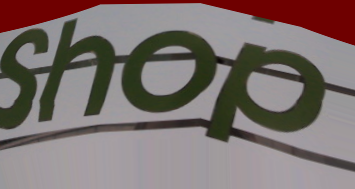

In [16]:
from PIL import Image
import random 
import cv2

image_path = "stretch_0.5/ICDAR2013/word_29.png"


# img = Image.open(image_path).convert('RGB')
img = cv2.imread(image_path)


# mean,std = cv2.meanStdDev(img)
# img = cv2.copyMakeBorder(img, 45,0,0,0,cv2.BORDER_CONSTANT, value=0)
# Image.fromarray(img)
# new_img = tia_stretch(img, 6,1.5)
new_img = tia_distort(img, 6 ,3)
Image.fromarray(new_img)


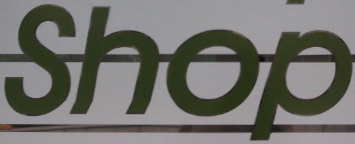

In [14]:
Image.fromarray(img)

findfont: Font family ['SimSun'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimSun'] not found. Falling back to DejaVu Sans.
findfont: Font family ['SimSun'] not found. Falling back to DejaVu Sans.


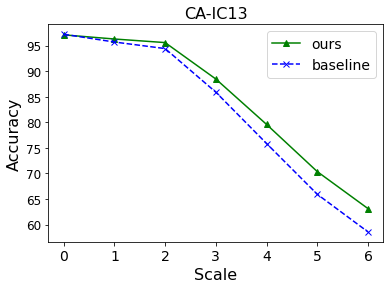

In [1]:
import matplotlib.pyplot as plt
dis_trans = [97.20, 95.68, 94.40, 85.88, 75.85 , 65.93, 58.58] 
dis_our = [97.08, 96.27, 95.57, 88.45, 79.58, 70.36, 63.13]
str_trans = [97.20 , 96.27, 95.45, 92.42, 86.46, 79.35, 72.46]
str_our = [97.08, 96.62, 96.15, 94.28, 89.96, 83.43, 77.71]
x = [0,1,2,3,4,5,6]
plt.rc('font',family='SimSun')
plt.plot(x, dis_our,"-g^", label='ours') 
plt.plot(x, dis_trans,"--bx", label='baseline')  # Plot some data on the (implicit) axes.
 
# plt.plot(x, str_trans, label='cubic')
plt.xlabel('Scale',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('Accuracy',fontsize=16)
plt.title("CA-IC13", fontsize=16)
plt.legend(fontsize=14)
plt.savefig("CA-IC13",dpi=100)
# plt.imsave("CA-IC13",arr= MxNx3)

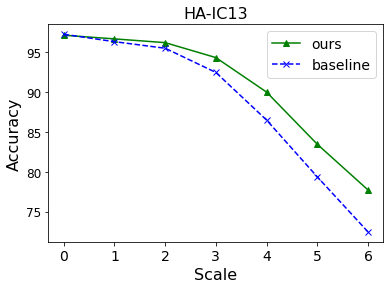

In [2]:
plt.plot(x, str_our,"-g^", label='ours') 
plt.plot(x, str_trans,"--bx", label='baseline')  # Plot some data on the (implicit) axes.
 
# plt.plot(x, str_trans, label='cubic')
# plt.xlabel('Scale')
# plt.ylabel('Accuracy')
# plt.title("HA-IC13")
# plt.legend()
# plt.savefig("HA-IC13_fig")
# plt.figure(figsize=(6,4))
plt.xlabel('Scale',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel('Accuracy',fontsize=16)
plt.title("HA-IC13", fontsize=16)
plt.legend(fontsize=14)
plt.savefig("HA-IC13", dpi=100)